In [ ]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Selection.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


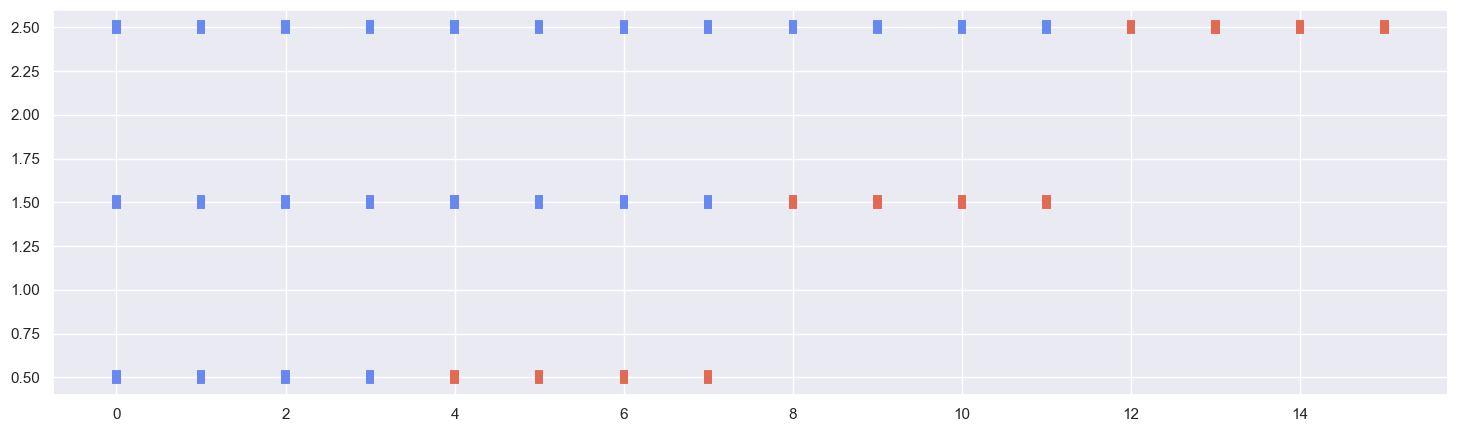

In [29]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [31]:
def data_scale():   
     scaler = StandardScaler()
     for col in df_red:
           if col not in ["price"]:
                  df_red[col]=scaler.fit_transform(df_red[[col]])

     for col in df_green:
           if col not in ["price"]:
                  df_green[col]=scaler.fit_transform(df_green[[col]])

     for col in df_yellow:
           if col not in ["price"]:
                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             


data_scale()

In [32]:
def train_test(data):
    tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
    models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


    test_data=data[-20:-4]
    time_series_data = test_data.values

    for model in models:
              for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred = model.predict(X_test)
                                  y_pred_results.append(y_pred)
                                  mae = np.mean(mean_absolute_error(y_test, y_pred))
                                  mae_scores.append(mae)    
                                  outcome=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_results[0:3]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[3:6]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[6:9]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[9:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[12:15]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[15:18]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[18:21]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[21:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[24:27]).stack().reset_index(drop=True))],axis=1)
                                  new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                                  new_date_index=pd.DataFrame({"date":new_date_index})
                                  outcome.columns=models_names
                                  outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

                                  outcome_mae=pd.concat([pd.DataFrame(pd.DataFrame(mae_scores[0:3]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[3:6]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[6:9]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[9:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[12:15]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[15:18]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[18:21]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[21:24]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[24:27]).stack().reset_index(drop=True))],axis=1)
                                  outcome_mae.columns=models_names
                                  
                                  




    return outcome_all,outcome_mae        

In [ ]:

df_red_outcomes=train_test(data=df_red)
df_green_outcomes=train_test(data=df_green)
df_yellow_outcomes=train_test(data=df_yellow)

In [34]:
pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,1.018969,0.710527,0.627591,0.691006,0.518795,0.542524,0.559524,0.988316,0.693893


In [39]:
pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,0.432405,0.378897,0.393838,0.532164,0.330586,0.356091,0.344409,0.644229,0.432169


In [40]:
pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score").T

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,0.944357,1.018351,1.004565,0.909346,1.074647,0.99535,0.955386,1.392562,1.095225


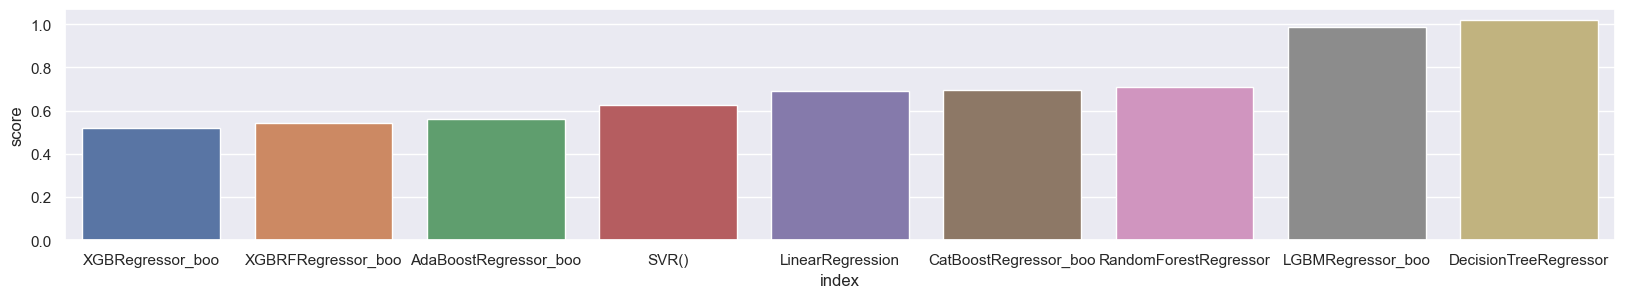

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

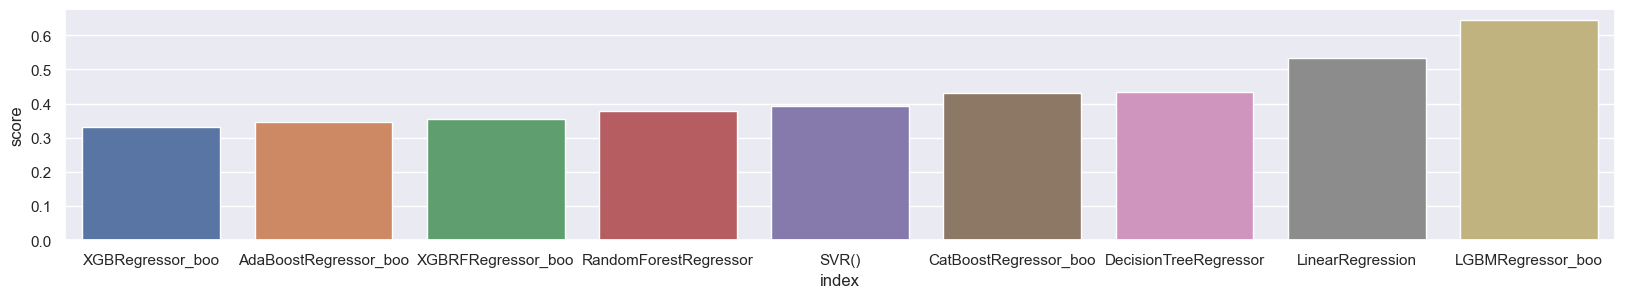

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

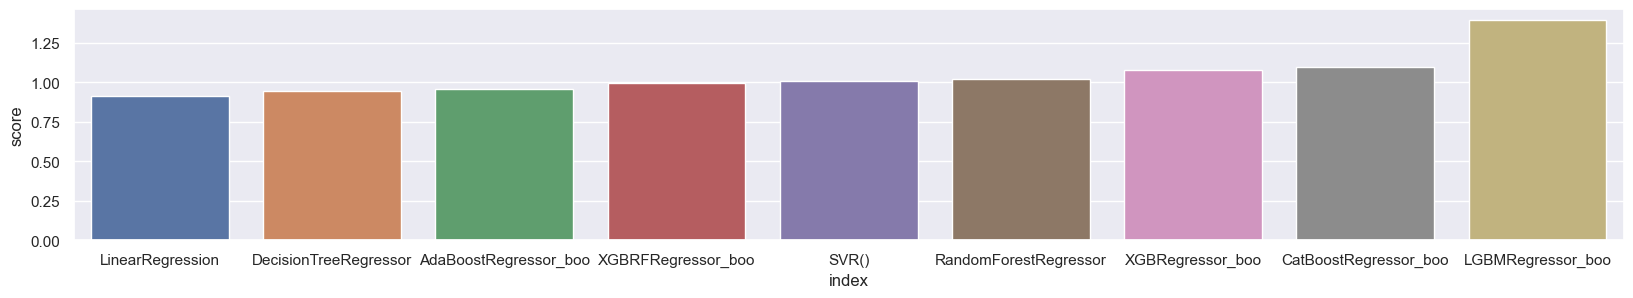

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

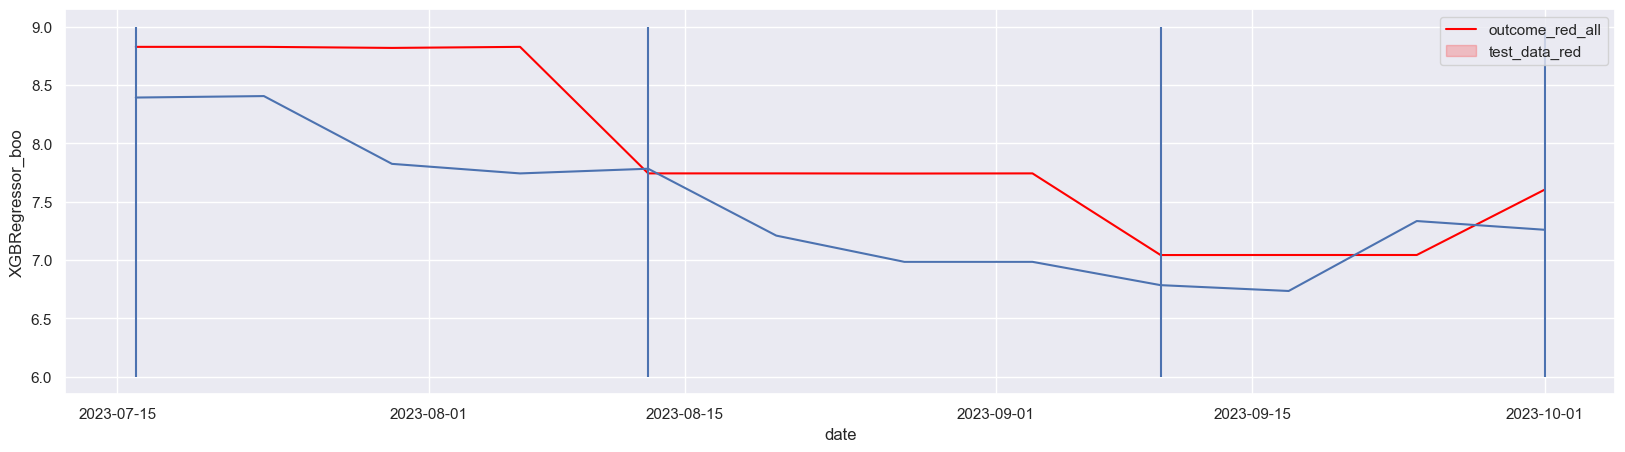

In [64]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(df_red_outcomes[0]['XGBRegressor_boo'],color="red");
sns.lineplot(df_red[-16:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_red_all","test_data_red"])

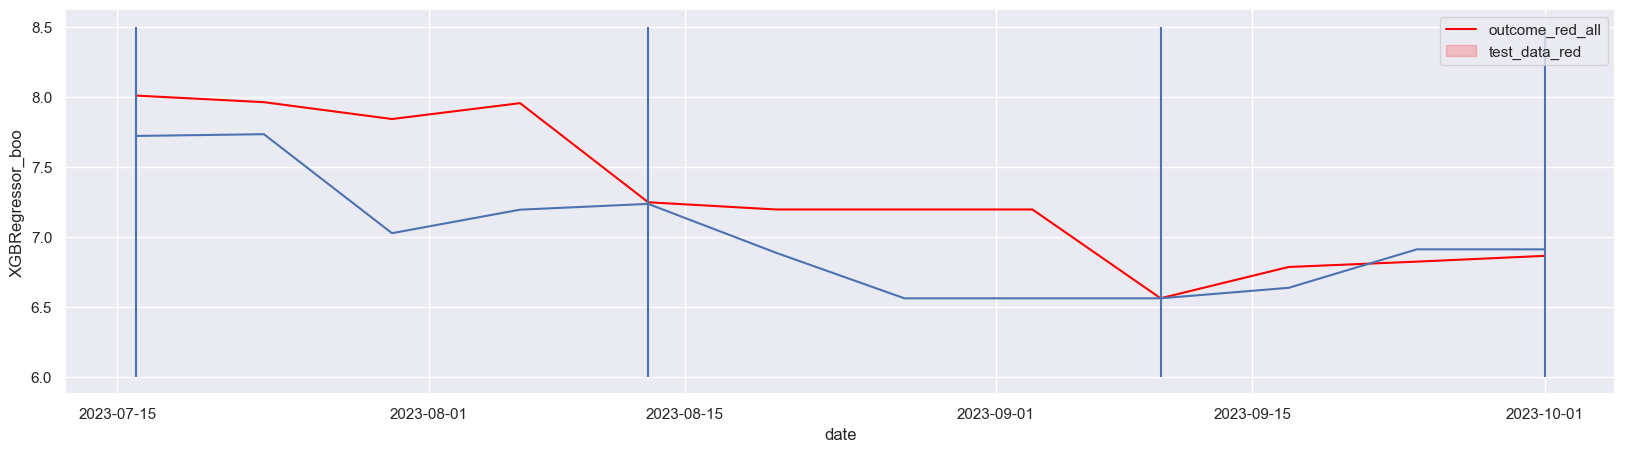

In [65]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 8.5
sns.lineplot(df_green_outcomes[0]['XGBRegressor_boo'],color="red");
sns.lineplot(df_green[-16:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_red_all","test_data_red"])

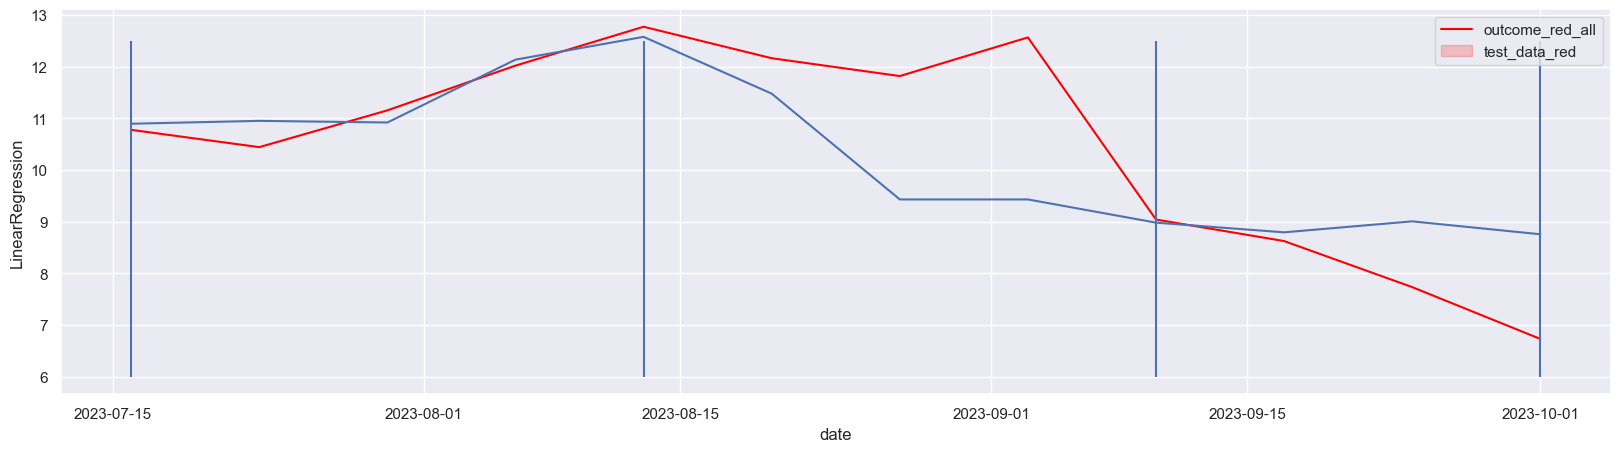

In [66]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 12.5
sns.lineplot(df_yellow_outcomes[0]['LinearRegression'],color="red");
sns.lineplot(df_yellow[-16:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_red_all","test_data_red"])

---

### *Forecasting*

* *We will copy the original datasets and crat new sets*

In [43]:
df_red_2=df_red.copy()
df_green_2=df_green.copy()
df_yellow_2=df_yellow.copy()

In [44]:
print(df_red_2.shape,df_green_2.shape,df_yellow_2.shape)

(402, 378) (402, 378) (402, 378)


* *Selecting the features we will drop after we shift the data for forecasting*

In [45]:
features_to_drop_red_forecast =list(df_red_2.columns)[13:]
features_to_drop_green_forecast =list(df_green_2.columns)[13:]
features_to_drop_yellow_forecast =list(df_yellow_2.columns)[13:]

* *shifting for 4 rows with 2 window rolling*

In [46]:
shift=[4]
Roll_Window=[2]
def features_shift_forecast():       
    
        for col in df_red_2:
           for s in shift:
               for w in Roll_Window:
                     df_red_2[f"{col}_shift_{s}_Rolling_{w}_forecast"]=df_red_2[col].rolling(window=w, min_periods=1).mean().shift(s)                   
                    
        for col in df_green_2:
           for s in shift:
               for w in Roll_Window:
                     df_green_2[f"{col}_shift_{s}_Rolling_{w}_forecast"]=df_green_2[col].rolling(window=w, min_periods=1).mean().shift(s)                  
                   
        for col in df_yellow_2:
            for s in shift:
                for w in Roll_Window:
                     df_yellow_2[f"{col}_shift_{s}_Rolling_{w}_forecast"]=df_yellow_2[col].rolling(window=w, min_periods=1).mean().shift(s)
                   
  
                  
features_shift_forecast()

In [47]:
df_green_2.dropna(axis=0,inplace=True)
df_red_2.dropna(axis=0,inplace=True)
df_yellow_2.dropna(axis=0,inplace=True)

In [48]:
def features_drop():
      
      df_red_2.drop(features_to_drop_red_forecast,axis=1,inplace=True)
      df_green_2.drop(features_to_drop_green_forecast,axis=1,inplace=True)    
      df_yellow_2.drop(features_to_drop_yellow_forecast,axis=1,inplace=True) 

features_drop()  

In [49]:
print(df_red_2.shape,df_green_2.shape,df_yellow_2.shape)

(398, 391) (398, 391) (398, 391)


1. *Forecasring the price the red color for the next for weeks by using the XGBRegressor model as it has the lowest mae*

In [51]:
for i in df_red_2:
     X_train, y_train = df_red_2[:-20].drop("price",axis=1), df_red_2[:-20]["price"]
     X_test, y_test = df_red_2[-4:].drop("price",axis=1), df_red_2[-4:]["price"]
     forecast_red=XGBRegressor(random_state=0).fit(X_train,y_train)
     forecast_red.predict(X_test) 

In [ ]:
pd.concat(df_red_2,

In [52]:
pd.DataFrame(forecast_red.predict(X_test))

,0
0,7.331466
1,7.208018
2,7.263535
3,7.019475


2. *Forecasring the price the green color for the next for weeks by using the XGBRegressor model as it has the lowest mae*

In [53]:
for i in df_green_2:                          

    X_train, y_train = df_green_2[:-20].drop("price",axis=1), df_green_2[:-20]["price"]
    X_test, y_test = df_green_2[-4:].drop("price",axis=1), df_green_2[-4:]["price"]
    forecast_green=XGBRegressor(random_state=0).fit(X_train,y_train)
    forecast_green.predict(X_test)

In [54]:
pd.DataFrame(forecast_green.predict(X_test))

,0
0,7.209377
1,6.791667
2,6.667784
3,6.833502


3. *Forecasring the price the yellow color for the next for weeks by using the LinearRegression model as it has the lowest mae*

In [55]:
for i in df_yellow_2:                          

    X_train, y_train = df_yellow_2[:-20].drop("price",axis=1), df_yellow_2[:-20]["price"]
    X_test, y_test = df_yellow_2[-4:].drop("price",axis=1), df_yellow_2[-4:]["price"]
    forecast_yellow=LinearRegression().fit(X_train,y_train)
    forecast_yellow.predict(X_test)

In [56]:
pd.DataFrame(forecast_yellow.predict(X_test))

,0
0,4.333592
1,9.789094
2,8.304334
3,10.707947


---